### Packages

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from utils import get_data
from utils import tech_order, tech_colors
import os

plt.style.use(['science','ieee'])
pd.options.display.float_format = '{:,.2f}'.format

### Load shape files

In [3]:
# Load the wecc load zones shape file
wecc_load_areas = gpd.read_file('shape_files/load_zones/wecc_load_areas.shp')
wecc_load_areas.rename(columns={'LOAD_AREA':'load_zone'}, inplace=True)
wecc_load_areas['centroid'] = wecc_load_areas['geometry'].apply(lambda x: x.centroid) #The centroids are later used to place pie charts

#Modify the centroids of canada load zones. Canada load zones occupy much space in the graph, so it is nice-looking to place the piecharts close to the US border
wecc_load_areas['centroid_partial_can'] = wecc_load_areas['centroid']
wecc_load_areas.loc[wecc_load_areas['load_zone']=='CAN_ALB', 'centroid_partial_can']= gpd.points_from_xy(x=[-112.50762] ,y=[50.77121])
wecc_load_areas.loc[wecc_load_areas['load_zone']=='CAN_BC', 'centroid_partial_can']= gpd.points_from_xy(x=[-119.73617] ,y=[50.77148])

wecc_load_areas.set_index('load_zone', inplace=True)
wecc_load_areas.head()

,PRIMARY_NE,PRIMARY_ST,ECONOMIC_M,RPS_COMPLI,RPS_COM_01,SUBSTATION,RPS_POLICY,geometry,centroid,centroid_partial_can
load_zone,,,,,,,,,,
CA_SMUD,CA,CA,1.08,"2,020.00",0.33,"22,311.00",1,"POLYGON ((-121.30796 38.74388, -121.30807 38.7...",POINT (-121.31822 38.47763),POINT (-121.31822 38.47763)
CA_SDGE,CA,CA,1.07,"2,020.00",0.33,"22,354.00",1,"POLYGON ((-117.59596 33.38675, -117.60791 33.4...",POINT (-116.80331 33.04453),POINT (-116.80331 33.04453)
CA_IID,AZNMSNV,CA,1.08,"2,020.00",0.33,"22,355.00",1,"POLYGON ((-116.10371 32.81595, -116.14226 32.8...",POINT (-115.56691 33.23078),POINT (-115.56691 33.23078)
CA_LADWP,CA,CA,1.07,"2,020.00",0.33,"44,357.00",1,"POLYGON ((-118.23875 34.26715, -118.25692 34.2...",POINT (-118.41021 34.11659),POINT (-118.41021 34.11659)
NV_S,AZNMSNV,NV,0.98,"2,025.00",0.25,"16,357.00",1,"POLYGON ((-114.66142 36.12203, -114.66289 36.1...",POINT (-115.37413 37.02327),POINT (-115.37413 37.02327)


### Load functions

In [4]:
def read_scenarios(file_name: str):
    input_scenarios=pd.read_csv(file_name, index_col=False)
    scenario = list(input_scenarios['scenario'])
    short_names = dict(input_scenarios[['scenario', 'short_name']].values)
    order= dict(input_scenarios[['short_name', 'order']].values)
    return scenario, short_names, order

In [5]:
def tech_generation(scenario, short_names, analysis_period, analysis_tech):
    dispatch_annual_summary = get_data(scenario, "dispatch_annual_summary.csv")
    dispatch_annual_summary.replace({"scenario": short_names}, inplace=True)
    
    if len(analysis_period)==0:
        analysis_period = dispatch_annual_summary.period.unique()
    if len(analysis_tech)==0:
        analysis_tech = dispatch_annual_summary.gen_energy_source.unique()

    dispatch_annual_summary = dispatch_annual_summary.loc[dispatch_annual_summary.gen_energy_source.isin(analysis_tech) &
                                                          dispatch_annual_summary.period.isin(analysis_period)]
    dispatch_annual_summary = dispatch_annual_summary[['tech_map','period', 'Energy_GWh_typical_yr','scenario']]
    dispatch_annual_summary = dispatch_annual_summary.pivot_table(index=['scenario','tech_map','period'], values=['Energy_GWh_typical_yr'], aggfunc=np.sum).reset_index(drop=False)
    total = dispatch_annual_summary.pivot_table(index='scenario', values='Energy_GWh_typical_yr', aggfunc=np.sum).reset_index(drop=False)
    total.rename(columns={'Energy_GWh_typical_yr' : 'Total_Energy_GWh_typical_yr'}, inplace=True)    
    dispatch_annual_summary = pd.merge(left = dispatch_annual_summary, right=total, on='scenario')
    
    dispatch_annual_summary['relative'] = dispatch_annual_summary['Energy_GWh_typical_yr']/dispatch_annual_summary['Total_Energy_GWh_typical_yr']*100

    return  dispatch_annual_summary, total

In [6]:
def tech_generation_by_zone(scenario, short_names, analysis_period, analysis_tech, analysis_zones):
    dispatch_annual_summary = get_data(scenario, "dispatch_zonal_annual_summary.csv")
    dispatch_annual_summary.replace({"scenario": short_names}, inplace=True)
    
    if len(analysis_period)==0:
        analysis_period = dispatch_annual_summary.period.unique()
    if len(analysis_tech)==0:
        analysis_tech = dispatch_annual_summary.tech_map.unique()
    if len(analysis_zones)==0:
        analysis_zones = dispatch_annual_summary.gen_load_zone.unique()

    dispatch_annual_summary = dispatch_annual_summary.loc[dispatch_annual_summary.tech_map.isin(analysis_tech) &
                                                          dispatch_annual_summary.period.isin(analysis_period)  &
                                                          dispatch_annual_summary.gen_load_zone.isin(analysis_zones)]
    dispatch_annual_summary = dispatch_annual_summary[['gen_load_zone','tech_map','period', 'Energy_GWh_typical_yr','scenario']]
    dispatch_annual_summary.rename(columns={'gen_load_zone' : 'load_zone'}, inplace=True)
    dispatch_annual_summary = dispatch_annual_summary.drop_duplicates().groupby(['load_zone', 'tech_map', 'period', 'scenario'], sort=False, as_index=False).sum()

    total_by_zone= dispatch_annual_summary.pivot_table(index = 'load_zone', values = 'Energy_GWh_typical_yr', aggfunc=np.sum)
    total_by_zone.rename(columns={'Energy_GWh_typical_yr' : 'Total_by_zone'}, inplace=True)
    total_by_zone.reset_index(inplace=True)

    dispatch_annual_summary = pd.merge(left=dispatch_annual_summary, right=total_by_zone, on='load_zone')
    dispatch_annual_summary ['Energy_relative'] = dispatch_annual_summary ['Energy_GWh_typical_yr']/dispatch_annual_summary ['Total_by_zone']
    dispatch_annual_summary = dispatch_annual_summary.replace(np.nan, 0)
    dispatch_annual_summary = dispatch_annual_summary[dispatch_annual_summary.Total_by_zone != 0]

    return  dispatch_annual_summary

In [7]:
def tx_cap_lw(scenario, short_names, analysis_period, analysis_zones, interval_length_existing_cap, interval_length_new_cap):
    #interval_length_existing_cap : if it is 5, there will be a new column with groups: 0 - 5, 5 - 10, ... 
    #  
    transmission_cap = get_data(scenario, "transmission.csv", usecols=['PERIOD', 'trans_lz1', 'trans_lz2', 'existing_trans_cap', 'BuildTx'])
    transmission_cap.replace({"scenario": short_names}, inplace=True)

    if len(analysis_period)==0:
        analysis_period = transmission_cap.PERIOD.unique()
    if len(analysis_zones)==0:
        analysis_zones = set(list(transmission_cap.trans_lz1) + list(transmission_cap.trans_lz2))

    transmission_cap = transmission_cap.loc[((transmission_cap.trans_lz1.isin(analysis_zones)) | (transmission_cap.trans_lz2.isin(analysis_zones)))]
    transmission_cap = transmission_cap.loc[transmission_cap.PERIOD.isin(analysis_period)]
    
    transmission_cap['existing_trans_cap']= transmission_cap['existing_trans_cap']/1000 #Tranform capacity from MW to GW
    
    transmission_cap["BuildTx"].replace({'.': 0}, inplace=True)
    transmission_cap["BuildTx"] = transmission_cap["BuildTx"].astype(float)
    transmission_cap['BuildTx'] = transmission_cap['BuildTx']/1000 ##Tranform capacity from MW to GW
    
    transmission_cap['existing_lw'] = (transmission_cap['existing_trans_cap']/interval_length_existing_cap).apply(np.ceil)
    transmission_cap['build_lw'] = (transmission_cap['BuildTx']/interval_length_new_cap).apply(np.ceil)

    return transmission_cap


### Load scenarios

In [8]:
scenario, short_names, order = read_scenarios("input_scenarios_wecc.csv")

folder_to_save_results='paper/'

#Check if the directory exists. If not, then create the directory.
if not os.path.exists(folder_to_save_results):
    os.makedirs(folder_to_save_results)

### Load generation

In [9]:
analysis_zones=[] 
analysis_period=[2035]
analysis_tech=[]

#Load generation dispatch by tech
zone_annual_gen = tech_generation_by_zone('baseline_pverde_ldes_5', {'baseline_pverde_ldes_5': 5},analysis_period, analysis_tech, analysis_zones)

techs_in_df = list(zone_annual_gen['tech_map'].unique())
missing_techs = set(tech_order) - set(techs_in_df)

zone_annual_gen_by_tech = zone_annual_gen.pivot_table(index='load_zone', columns='tech_map', values='Energy_relative')

zone_annual_gen_by_tech = pd.merge(left =zone_annual_gen_by_tech, right=zone_annual_gen[['load_zone', 'Total_by_zone']].drop_duplicates().set_index('load_zone'), left_index=True, right_index=True)
zone_annual_gen_by_tech = pd.merge(left= zone_annual_gen_by_tech, right=wecc_load_areas[['centroid_partial_can']], left_index=True, right_index=True)

for i in missing_techs:
    zone_annual_gen_by_tech[i]=0.00
zone_annual_gen_by_tech['log_Total_by_zone'] = np.log(zone_annual_gen_by_tech['Total_by_zone'])
zone_annual_gen_by_tech.head()


,Storage,Biomass,Gas,Solar,Coal,Oil,Geothermal,Hydro,Nuclear,Waste,Wind,Total_by_zone,centroid_partial_can,log_Total_by_zone
load_zone,,,,,,,,,,,,,,
AZ_APS_E,0.95,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,401.39,POINT (-110.09621 34.38540),5.99
AZ_APS_N,0.22,0.01,0.00,0.18,0.00,0.00,0.00,0.59,0.00,0.00,0.00,"6,571.03",POINT (-112.24571 35.67142),8.79
AZ_APS_SW,0.19,0.00,0.00,0.44,0.00,0.00,0.00,0.00,0.36,0.00,0.00,"85,650.21",POINT (-113.40839 33.22903),11.36
AZ_NM_N,0.11,0.00,0.00,0.87,0.00,0.00,0.00,0.02,0.00,0.00,0.00,"6,071.52",POINT (-109.23803 36.13718),8.71
AZ_NW,0.28,0.00,0.00,0.63,0.00,0.00,0.00,0.09,0.00,0.00,0.00,"12,103.81",POINT (-113.97357 35.21137),9.40


In [10]:
tech_colors_in_order = [tech_colors[i] for i in tech_order]

tech_to_color = dict(zip(tech_order, tech_colors_in_order))

# Filter tech_order to show only the technologies in analysis_tech
filtered_tech_order = [tech for tech in tech_order if tech in analysis_tech]

# Filter tech_colors_in_order to show only the colors corresponding to the technologies in analysis_tech
filtered_tech_colors_in_order = [tech_to_color[tech] for tech in filtered_tech_order]

print(filtered_tech_order)
print(filtered_tech_colors_in_order)

[]
[]


### Load transmission

In [11]:
#Load transmission capacity
len_ex = 10; #length of interval to plot for the existing lines
len_b = 2; #length of interval to plot for the new builtout

tx_cap = tx_cap_lw('baseline_pverde_ldes_5', {'baseline_pverde_ldes_5': 5}, analysis_period, analysis_zones, len_ex, len_b)
tx_cap = pd.merge(left=tx_cap, right=wecc_load_areas[['centroid_partial_can']].reset_index().rename(columns={'load_zone' : 'trans_lz1'}), on='trans_lz1')
tx_cap.rename(columns={'centroid_partial_can': 'coordinate_trans_lz1'}, inplace=True)
tx_cap = pd.merge(left=tx_cap, right=wecc_load_areas[['centroid_partial_can']].reset_index().rename(columns={'load_zone' : 'trans_lz2'}), on='trans_lz2')
tx_cap.rename(columns={'centroid_partial_can': 'coordinate_trans_lz2'}, inplace=True)
tx_cap

,PERIOD,trans_lz1,trans_lz2,existing_trans_cap,BuildTx,scenario,existing_lw,build_lw,coordinate_trans_lz1,coordinate_trans_lz2
0,2035,AZ_APS_E,AZ_APS_N,0.28,0.00,5,1.00,0.00,POINT (-110.09621 34.38540),POINT (-112.24571 35.67142)
1,2035,AZ_APS_E,AZ_NM_N,3.50,0.00,5,1.00,0.00,POINT (-110.09621 34.38540),POINT (-109.23803 36.13718)
2,2035,AZ_APS_N,AZ_NM_N,2.01,0.00,5,1.00,0.00,POINT (-112.24571 35.67142),POINT (-109.23803 36.13718)
3,2035,AZ_APS_E,AZ_PHX,2.93,0.00,5,1.00,0.00,POINT (-110.09621 34.38540),POINT (-111.52754 33.54230)
4,2035,AZ_APS_N,AZ_PHX,4.01,0.00,5,1.00,0.00,POINT (-112.24571 35.67142),POINT (-111.52754 33.54230)
...,...,...,...,...,...,...,...,...,...,...
121,2035,MT_SW,WY_NW,0.00,0.00,5,0.00,0.00,POINT (-111.96387 45.59600),POINT (-108.74349 43.87674)
122,2035,WY_NE,WY_NW,0.00,0.00,5,0.00,0.00,POINT (-105.00997 44.33387),POINT (-108.74349 43.87674)
123,2035,MT_NE,MT_SE,0.69,2.71,5,1.00,2.00,POINT (-109.91967 47.75704),POINT (-107.33684 45.70949)
124,2035,MT_SE,WY_NE,0.33,0.77,5,1.00,1.00,POINT (-107.33684 45.70949),POINT (-105.00997 44.33387)


### Plot

(29.922504, 52.515181)

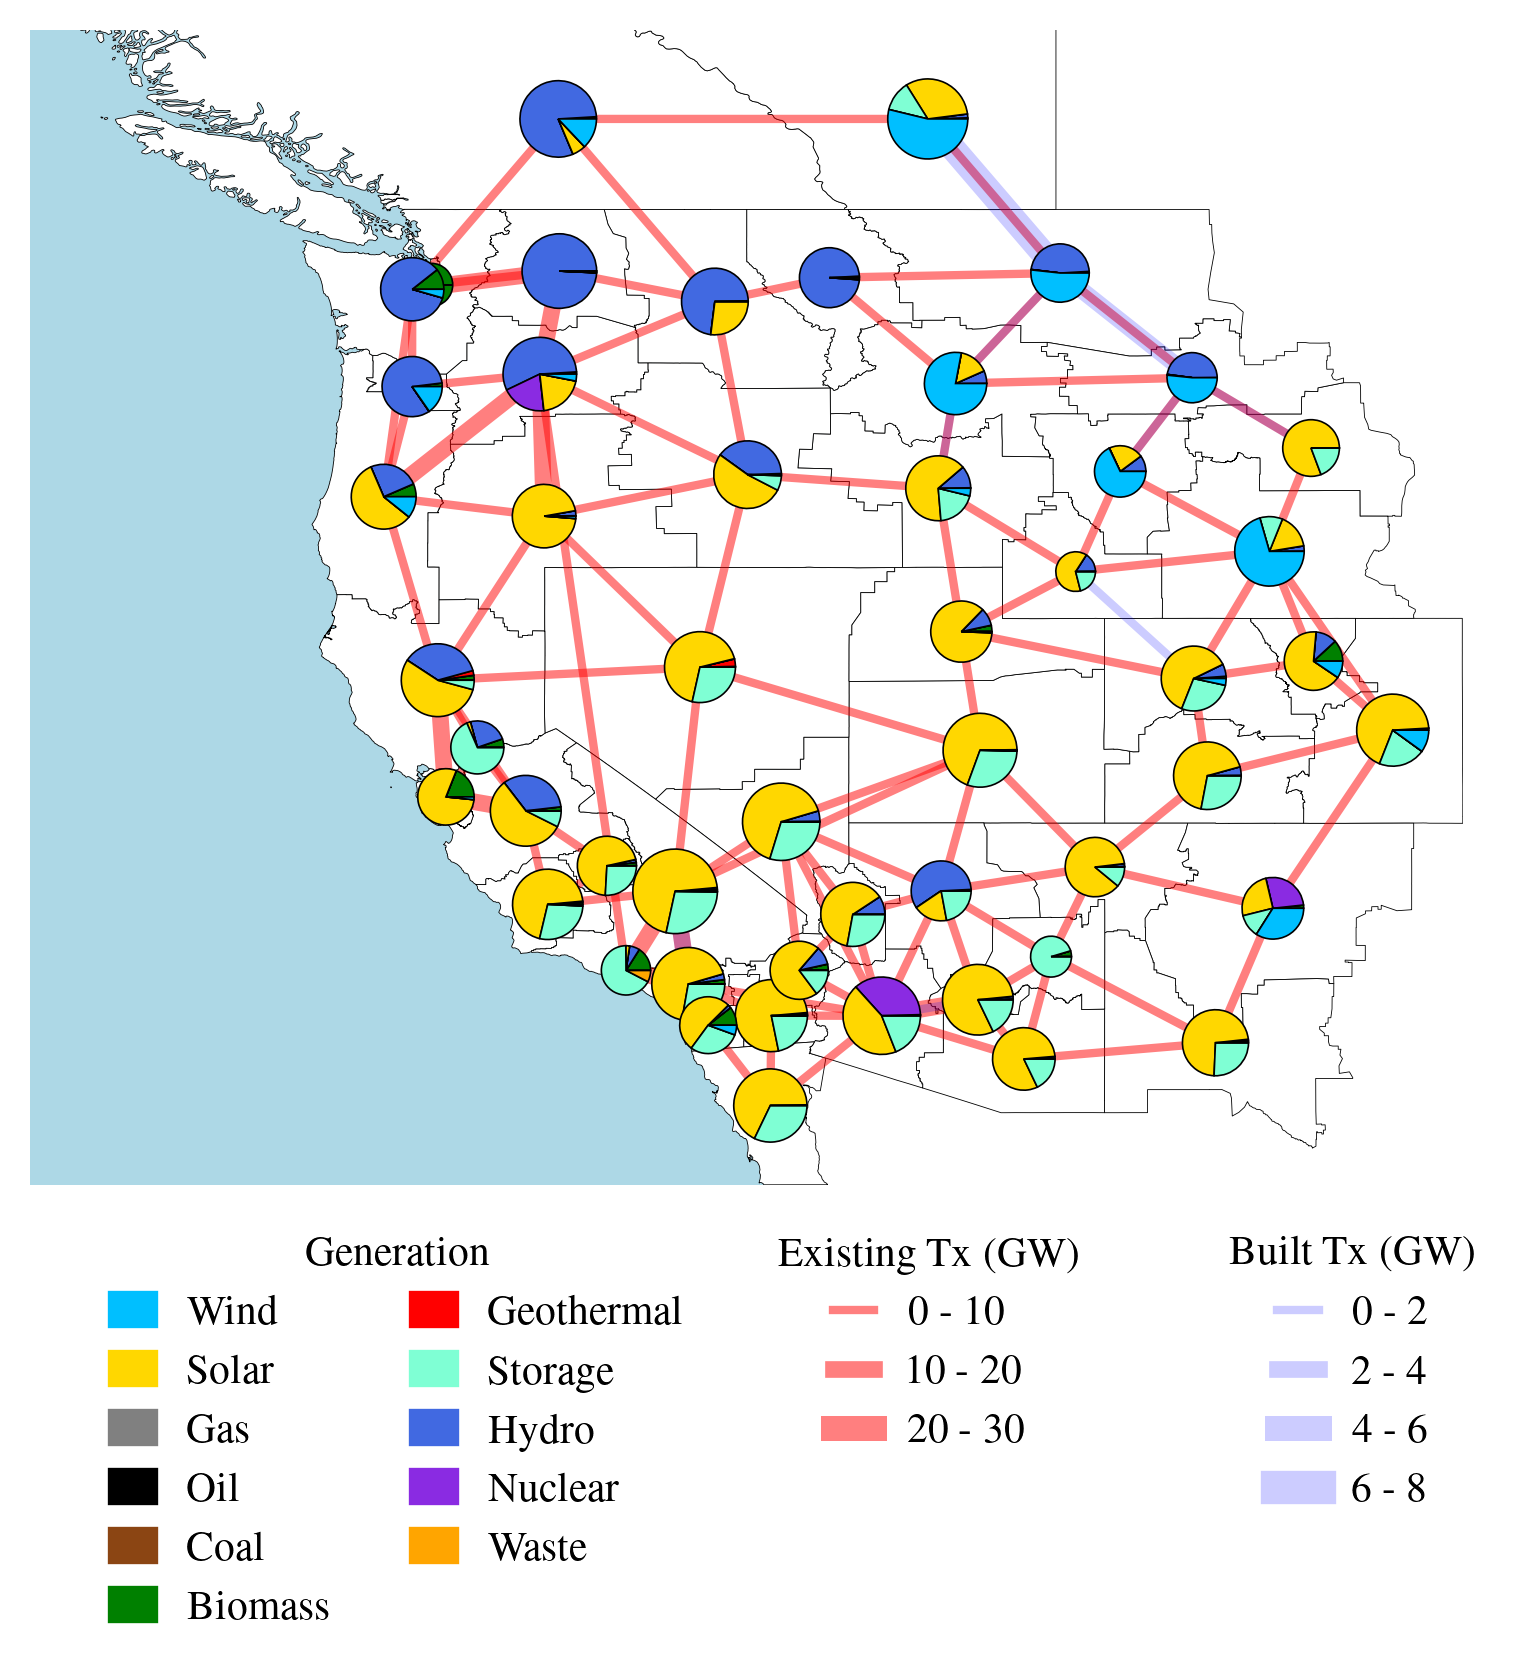

In [14]:
# Create the base map
fig, ax = plt.subplots()

# Create a bounding box polygon that covers the entire extent of the plot
xmin, ymin, xmax, ymax = wecc_load_areas.total_bounds
bbox = np.array([[xmin, ymin], [xmin, ymax], [xmax-12, ymax-12], [xmax-15, ymin-15], [xmin-15, ymin-15]]) #-12, -15 were set to cut half on the sky polygon because the ocean is on the left of the map
#Create the polygon
bbox_poly = plt.Polygon(bbox, facecolor='#ADD8E6')
# Add the bounding box polygon to the plot
ax.add_patch(bbox_poly)

#Add wecc map
ax = wecc_load_areas.plot(ax=ax, linewidth=0.1, facecolor='white', edgecolor='black')

#Add existing transmission lines and new capacity with corresponding capacity
for idx, row in tx_cap.iterrows():
    if row['existing_trans_cap']>0: #We only show non zero cap lines 
        ax.plot([row['coordinate_trans_lz1'].x, row['coordinate_trans_lz2'].x],[row['coordinate_trans_lz1'].y, row['coordinate_trans_lz2'].y], 
                lw=row['existing_lw'], linestyle='-', color='red', alpha=0.5, zorder = 1) #the zorder makes the lines to overlap the piecharts

    if row['BuildTx']>0:
        ax.plot([row['coordinate_trans_lz1'].x, row['coordinate_trans_lz2'].x],[row['coordinate_trans_lz1'].y, row['coordinate_trans_lz2'].y], 
                lw=row['build_lw'], linestyle='-', color='blue', alpha=0.2, zorder=1) #the zorder makes the lines to overlap the piecharts

#Add pie charts that display generation portfolio
for idx, row in zone_annual_gen_by_tech.iterrows():
    proportions = row[tech_order]
    ax.pie(proportions, radius = row['log_Total_by_zone']/15, center=row['centroid_partial_can'].coords[0], colors=tech_colors_in_order,
               wedgeprops={"edgecolor":"black",'linewidth':0.2,'antialiased':True})

#Legend of the existing tx
handles_existing_tx = [Line2D([0], [0], label= (str(k*len_ex) + str(' - ') + str((k+1)*len_ex)), alpha=0.5,  lw = k+1, color='red') 
                                for k in range(0,int(np.ceil(tx_cap['existing_trans_cap'].max())/len_ex)+1, 1)]

fig.legend( handles = handles_existing_tx, title='Existing Tx (GW)', bbox_to_anchor=(0.7,0.1), fontsize = 5, title_fontsize=5, ncol=1, handlelength=1)

#Legend of the new tx capacity
handles_build_tx = [Line2D([0], [0], label= (str(k*len_b) + str(' - ') + str((k+1)*len_b)), alpha=0.2, lw = k+1, color='blue') 
                                for k in range(0,int(np.ceil(tx_cap['BuildTx'].max())/len_b)+1, 1)]

fig.legend(handles = handles_build_tx, title='Built Tx (GW)', bbox_to_anchor=(0.9,0.1), fontsize = 5, title_fontsize=5, ncol=1, handlelength=1)

#Legend of the generation portfolio
handles_gen_tech = [mpatches.Patch( color=tech_colors[k], label=k)  for k in tech_colors.keys()]

fig.legend(handles = handles_gen_tech, title='Generation',  bbox_to_anchor=(0.5,0.1), fontsize = 5, title_fontsize=5, ncol=2,  handlelength=1)

ax.set_xlim(wecc_load_areas.total_bounds[[0, 2]]+[9,0])
ax.set_ylim(wecc_load_areas.total_bounds[[1, 3]]-[0,7.5])